In [148]:
from collections import defaultdict
import os
import pickle
import re

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['ps.usedistiller'] = 'xpdf'


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

In [2]:
def open_report(pickle_file, verbose=True):
    with open(pickle_file, 'br') as f:
        report = pickle.load(f)

    if verbose:
        print('\nfile_name: {}\nmodel:{}'.format(pickle_file, report['model']))
    
    return report

def KLDivergence(P, Q):
    sdklist = []
    for i, (p, q) in enumerate(zip(P, Q)):
        sdk = 0 if p == 0 else p*np.log2(p/q)
        sdk += 0 if p == 1 else (1-p) * np.log2((1-p)/(1-q))
        sdklist.append(sdk)

    return np.array(sdklist)


In [8]:
basepath = './partial/'
pickle_files = [basepath + n for n in  os.listdir(basepath) if '.pkl' in n]

models = [
    'RMch',
    'RMchD',
    'C5o6RMch',
    'C5o6RMchD',
    'C5o6C5o12RMchD',
    'C5o6C5o12Rfl100MchD',
    'C5o6C5o12C5o36C5o36RMchD',
    'C5o6C5o12C5o36C5o36Rfl100MchD',
]

reports_1e3 = {}
reports_1e4 = {}
reports_by_model = defaultdict(list)

for fname in pickle_files:
    report = open_report(fname, verbose=False)
    model_name = str(report['model_name'])
    
    assert model_name in models
    
    reports_by_model[model_name].append(report)
    
    if report['lrange'][0] == 1e-3:
        reports_1e3[model_name] = report
    
    if report['lrange'][0] == 1e-4:
        reports_1e4[model_name] = report


assert len(reports_1e3) == len(reports_1e4)
assert len(reports_by_model) == len(models)
assert len(reports_1e4) == len(models)

print(list(reports_1e3.keys()))

['C5o6RMchD', 'C5o6C5o12C5o36C5o36Rfl100MchD', 'C5o6C5o12Rfl100MchD', 'C5o6C5o12C5o36C5o36RMchD', 'RMchD', 'C5o6RMch', 'C5o6C5o12RMchD', 'RMch']


In [110]:
def build_report_dict(report):
    df_test = report['df_test']
    df_train = report['df_train']
    train_time_series = df_test['train_time'].as_matrix()[1:]
    total_time_series = df_test['total_time'].as_matrix()[1:]
    return {
        'name': report['model_name'],
        'lrate': report['lrange'][0],
        'train_loss': df_train['loss_avg'].iloc[-1],
        'test_loss': df_test['loss_avg'].iloc[-1],

        'train_wacc': df_train['wacc'].iloc[-1],
        'test_wacc': df_test['wacc'].iloc[-1],

        'train_wprob': df_train['wprob'].iloc[-1],
        'test_wprob': df_test['wprob'].iloc[-1],

        'test_wacc_max': df_test['wacc'].max(),
        'mean_time': train_time_series.mean(),
        'std_time': train_time_series.std(),
        'total_std_time': total_time_series.std(),
        'total_mean_time': total_time_series.mean(),
        'size': report['model_size'],
    }

reports_dict_list = []
for model in models:
    reports = reports_by_model[model]
    reports_dict_list.append(build_report_dict(reports_1e3[model]))
    reports_dict_list.append(build_report_dict(reports_1e4[model]))
        
df_comp = pd.DataFrame(reports_dict_list)
reports_groups_by_name = df_comp.groupby('name')

def explore_by_group(funct):
    for model in models:
        group = reports_groups_by_name.get_group(model)
        data = funct(group)
        print('\n%',model)
        print(data)

In [151]:
PLT_COLORS = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]

models_alias = {
    'RMch': '$M$',
    'RMchD': '$MD$',
    'C5o6RMch': '$C_6M$',
    'C5o6RMchD': '$C_6MD$',
    'C5o6C5o12RMchD': '$C_6C_{12}MD$',
    'C5o6C5o12Rfl100MchD': '$C_6C_{12}Fl_{100}MD$',
    'C5o6C5o12C5o36C5o36RMchD': '$C_6C_{12}C_{36}C_{36}MD$',
    'C5o6C5o12C5o36C5o36Rfl100MchD': '$C_6C_{12}C_{36}C_{36}Fl_{100}MD$',
}

models_alias2 = {
    'RMch': '(a)',
    'RMchD': '(b)',
    'C5o6RMch': '(c)',
    'C5o6RMchD': '(d)',
    'C5o6C5o12RMchD': '(e)',
    'C5o6C5o12Rfl100MchD': '(f)',
    'C5o6C5o12C5o36C5o36RMchD': '(g)',
    'C5o6C5o12C5o36C5o36Rfl100MchD': '(h)',
}


def smooth(ys, alpha=0.1):
    _ys = []
    _y = ys[0]
    for y in ys:
        _y = (1 - alpha) * _y + alpha * y
        _ys.append(_y)
    
    return _ys

for k, model in enumerate(models):
    reports = reports_by_model[model]
        
    plt.figure(k)
    for m, report in enumerate(sorted(reports, key=lambda x: x['lrange'][0], reverse=True)):
        color = PLT_COLORS[m]
        df_test = report['df_test']
        y = df_test['loss_avg']
        x = df_test['epoch']
        plt.plot(x, y, 'o-', label='${:1.0e}$'.format(report['lrange'][0]).replace('1e-0', '\eta='), **{'color':color})
    
        #plt.plot(x, y.as_matrix(), '-', **{'color':color})
    
    font_params = {'family': 'monospace', 'size': 'large', }    
    plt.yscale('log')
    plt.title('{} {}'.format(models_alias2[model], models_alias[model]), **{'size': 18})
    plt.legend()
    #plt.savefig('../../reports/tcc/figuras/{}.eps'.format(model), bbox_inches='tight')
    #plt.close()

In [102]:
def explore_times(group):
    columns_time = ['name', 'size', 'lrate', 'mean_time', 'std_time', 'total_mean_time', 'total_std_time']
    data = group[columns_time].sort_values('lrate', ascending=False)
    data['dev_time'] = data['std_time']/data['mean_time']
    data['total_dev_time'] = data['total_std_time']/data['total_mean_time']
    data['alias'] = data['name'].apply(lambda x: models_alias[x])

    data2 = data[['alias', 'size',  'lrate', 'mean_time', 'total_mean_time']].copy()
    
    data2['%'] = data2['mean_time'] / data2['total_mean_time']
    
    return data2[['alias', 'size',  'lrate', 'mean_time', 'total_mean_time', '%']]
    

    formatters = {
        'lrate': lambda x: re.sub('1e-0(\d)', '10^{-\g<1>}', '${:1.0e}$'.format(x)),
        'size': lambda x: re.sub('e\+0(\d)', '\,10^{\g<1>}', '${:1.1e}$'.format(x)),
        'mean_time': lambda x: '${:.2f}$'.format(x),
        'total_mean_time': lambda x: '${:.2f}$'.format(x),
    }
    
    for key, form in formatters .items():
        data[key] = data[key].apply(form)
    
    alias = data['alias'].iloc[0]
    size = data['size'].iloc[0]

    #first_line = '\multirow{2}{*}{' + alias + '} & \multirow{2}{*}{' + size + '} &\n'
    
    first_line = '' + alias + ' & ' + size + ' & '
    next_line = '&  &'
    
    lines = []
    for k, row in enumerate(data.as_matrix()[:, 2:]):
        comp = '{} & {} & {} \\\\ \hline'.format(*row)
        if k == 0:
            lines.append(first_line + comp)
        else:
            continue
            lines.append(next_line + comp)
    
    return '\n'.join(lines) + '\hline'
    
    
explore_by_group(explore_times)



% RMch
  alias     size   lrate  mean_time  total_mean_time         %
0   $M$  5400000  0.0010  72.629409       100.973703  0.719290
1   $M$  5400000  0.0001  72.613481       100.942723  0.719353

% RMchD
  alias     size   lrate  mean_time  total_mean_time         %
2  $MD$  5400000  0.0010  75.956043       108.142967  0.702367
3  $MD$  5400000  0.0001  75.898028       108.054004  0.702408

% C5o6RMch
    alias     size   lrate  mean_time  total_mean_time        %
4  $C_6M$  2434770  0.0010  66.960441        91.237918  0.73391
5  $C_6M$  2434770  0.0001  66.987730        91.256420  0.73406

% C5o6RMchD
     alias     size   lrate  mean_time  total_mean_time         %
6  $C_6MD$  2434770  0.0010  71.185433        97.567478  0.729602
7  $C_6MD$  2434770  0.0001  71.178437        97.567628  0.729529

% C5o6C5o12RMchD
           alias     size   lrate   mean_time  total_mean_time         %
8  $C_6C_{12}MD$  4356810  0.0010  238.656694       291.029510  0.820043
9  $C_6C_{12}MD$  4356810 

In [142]:
def explore_performance(group):
    model_name = group['name'].iloc[0]
    alias1 = models_alias[model_name]
    alias2 = models_alias2[model_name]
    
    columns = ['lrate', 'train_loss', 'train_wacc', 'train_wprob', 'test_loss', 'test_wprob', 'test_wacc']
    data = group[columns].sort_values('lrate', ascending=False)
    data['loss_rel'] = data['test_loss']/data['train_loss'] - 1
    data['q_p'] = data['test_wprob']/(data['train_wacc'] + 1e-10)
    
    return data[['lrate', 'test_loss', 'q_p']]
    
    
    #print(re.sub('e\+0(\d)', ' $10^{\g<1>}$', model))
    
    formatters = {
        'lrate': lambda x: re.sub('1e-0(\d)', '10^{-\g<1>}', '${:1.0e}$'.format(x)),
        'train_loss': lambda x: re.sub('e-0(\d)', '\,10^{-\g<1>}', '${:1.2e}$'.format(x)),
        'train_wacc': lambda x: '${:.2f}$'.format(x),
        'train_wprob': lambda x: '${:.2f}$'.format(x),        
        'test_loss': lambda x: re.sub('e-0(\d)', '\,10^{-\g<1>}', '${:1.2e}$'.format(x)),
        'test_wacc': lambda x: '${:.2f}$'.format(x),
        'loss_rel': lambda x: '${:.2f}$'.format(x),
        'test_wprob': lambda x: '${:.2f}$'.format(x),
    }
    
    for key, form in formatters.items():
        data[key] = data[key].apply(form)
    
    #data = data[['lrate', 'train_loss', 'train_wacc', 'train_wprob', 'test_loss', 'test_wacc', 'train_wprob', 'loss_rel']]
    #line_form = '& {} & {} & {} & {} & {} & {} & {} & {} \\\\ \cline{{2-9}}'.format
    
    data = data[['lrate', 'train_loss', 'train_wacc', 'test_loss', 'test_wacc', 'loss_rel']]
    line_form = '& {} & {} & {} & {} & {} & {} \\\\ \cline{{2-7}}'.format

    
    first_line = '\hline\hline\n\multirow{{2}}{{*}}{{{}}}\n'.format(alias2 + ' '+ alias1)    
        
    lines = []
    for row in data.as_matrix():
        lines.append(line_form(*row))    
    
    return first_line + '\n'.join(lines)


explore_by_group(explore_performance)



% RMch
    lrate  test_loss       q_p
0  0.0010   0.398015  0.422579
1  0.0001   0.093437  0.430855

% RMchD
    lrate  test_loss       q_p
2  0.0010   0.330733  0.465752
3  0.0001   0.117314  0.529943

% C5o6RMch
    lrate  test_loss       q_p
4  0.0010   0.119610  0.435766
5  0.0001   0.073407  0.455460

% C5o6RMchD
    lrate  test_loss       q_p
6  0.0010   0.065567  0.494134
7  0.0001   0.060243  0.566056

% C5o6C5o12RMchD
    lrate  test_loss       q_p
8  0.0010   0.044894  0.633995
9  0.0001   0.042099  0.693738

% C5o6C5o12Rfl100MchD
     lrate  test_loss       q_p
10  0.0010   0.043406  0.703014
11  0.0001   0.041573  0.687154

% C5o6C5o12C5o36C5o36RMchD
     lrate  test_loss       q_p
12  0.0010   0.016150  0.895146
13  0.0001   0.029142  0.849668

% C5o6C5o12C5o36C5o36Rfl100MchD
     lrate  test_loss       q_p
14  0.0010   0.016564  0.900084
15  0.0001   0.025245  0.863554


(a) $M$
(b) $MD$
(c) $C_6M$
(d) $C_6MD$
(e) $C_6C_{12}MD$
(f) $C_6C_{12}Fl_{100}MD$
(g) $C_6C_{12}C_{36}C_{36}MD$
(h) $C_6C_{12}C_{36}C_{36}Fl_{100}MD$


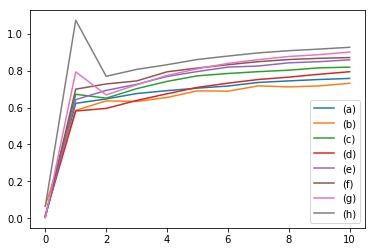

In [147]:
plt.figure()
for k, model in enumerate(models):
    reports = reports_by_model[model]

    for m, report in enumerate(sorted(reports, key=lambda x: x['lrange'][0], reverse=True)):
        if report['lrange'][0] != 1e-4:
            continue
    
        color = PLT_COLORS[m]
        df_test = report['df_test']
        x = df_test['epoch']
        
        p = df_test['wacc']
        q = df_test['wprob']
        
        y = q/(p + 1e-6)#KLDivergence(p, q)
        plt.plot(x, y, label=models_alias2[model])
        print('{} {}'.format(models_alias2[model], models_alias[model]))
        #for n in range(5):
        #    y = df_test['acc_{}'.format(n)]
        #    plt.plot(x, 1-y)
            
        #plt.plot(x, y, 'o-', label='{:1.0e}'.format(report['lrange'][0]), **{'color':color})
    
        #plt.plot(x, y.as_matrix(), '-', **{'color':color})
    
font_params = {'family': 'monospace', 'size': 'large', }    
#plt.yscale('log')
#plt.title('{} {}'.format(models_alias2[model], models_alias[model]), **{'size': 18})
plt.legend()
#plt.ylim([0.6, 1])
#plt.xlim([6, 10])

In [224]:
for model in models:
    report = reports_1e3[model]
    total_params = 0
    print()
    print('\\noindent')
    print('\\begin{tabularx}{\linewidth}{ |c|X|c|c|c| }')
    print('\multicolumn{5}{c}{' + models_alias[model] + '} \\\\ \hline \hline')
    print('Camada & Descrição & Entrada & Saída & Parâmetros \\\\ \hline')
    for c in report['model']:
        if 'InputLayer' in c:
            continue
        
        res = re.search('\(\((.*)\) -> \((.*)\)\)', c.replace('?, ', ''))
        size_in = [int(x) for x in res.group(1).split(',')]
        size_out = [int(x) for x in res.group(2).split(',')]
        
        model = re.search('\..*\.(.*?)\(', c).group(1)
        params = 0
        desc = ''
        if 'ConvLayer' in model:
            model = '$C_{{{}}}$'.format(size_out[-1])
            params = 25 *  size_in[-1] * size_out[-1]
            desc = 'Convolucional com {} canais de entrada e {} de saída'.format(size_in[-1], size_out[-1])
        elif 'LinearReshapeLayer' in model:
            model = 'Lin'
            desc = '-'
        elif 'LinearMultiCharOutputLayer' in model:
            model = '$M$'
            desc = '5 classificadores.'
            params = 180 * size_in[-1]
        elif 'LinearLayer' in model:
            model = '$Fl_{{{}}}$'.format(size_out[-1])
            desc  = 'Camada densa com {} sinais de entrada e {} sinais de saída.'.format(size_in[-1], size_out[-1])
            params = size_in[-1] * size_out[-1]
        elif 'DropOutLayer' in c:
            continue
            
        total_params += params
        print('{} & {} & ({}) & ({}) & {} \\\\ \hline'.format(model, desc, ','.join(map(str, size_in)), ','.join(map(str, size_out)), params))
    
    print(' total &  &  &  & {} \\\\ \hline'.format(total_params))
    print('\end{tabularx}')



\noindent
\begin{tabularx}{\linewidth}{ |c|X|c|c|c| }
\multicolumn{5}{c}{$M$} \\ \hline \hline
Camada & Descrição & Entrada & Saída & Parâmetros \\ \hline
Lin & - & (50,200,3) & (30000) & 0 \\ \hline
$M$ & 5 classificadores. & (30000) & (5,36) & 5400000 \\ \hline
 total &  &  &  & 5400000 \\ \hline
\end{tabularx}

\noindent
\begin{tabularx}{\linewidth}{ |c|X|c|c|c| }
\multicolumn{5}{c}{$MD$} \\ \hline \hline
Camada & Descrição & Entrada & Saída & Parâmetros \\ \hline
Lin & - & (50,200,3) & (30000) & 0 \\ \hline
$M$ & 5 classificadores. & (30000) & (5,36) & 5400000 \\ \hline
 total &  &  &  & 5400000 \\ \hline
\end{tabularx}

\noindent
\begin{tabularx}{\linewidth}{ |c|X|c|c|c| }
\multicolumn{5}{c}{$C_6M$} \\ \hline \hline
Camada & Descrição & Entrada & Saída & Parâmetros \\ \hline
$C_{6}$ & Convolucional com 3 canais de entrada e 6 de saída & (50,200,3) & (23,98,6) & 450 \\ \hline
Lin & - & (23,98,6) & (13524) & 0 \\ \hline
$M$ & 5 classificadores. & (13524) & (5,36) & 2434320 \\ \hlin

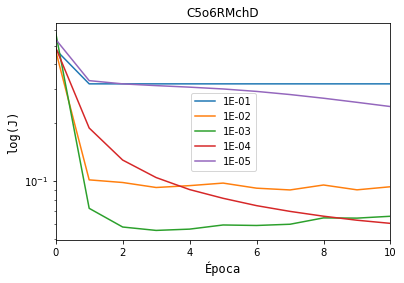

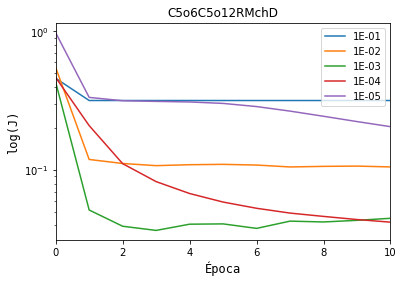

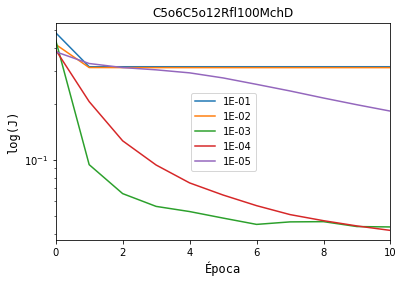

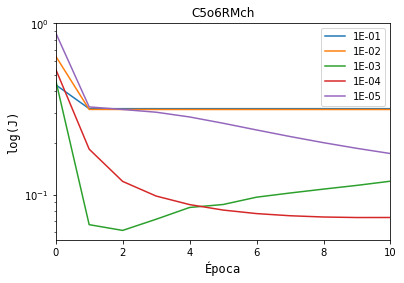

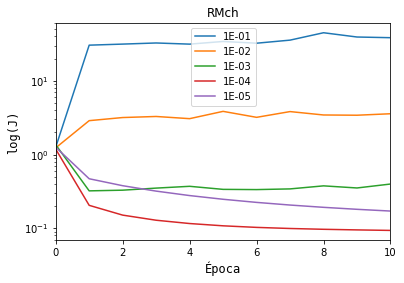

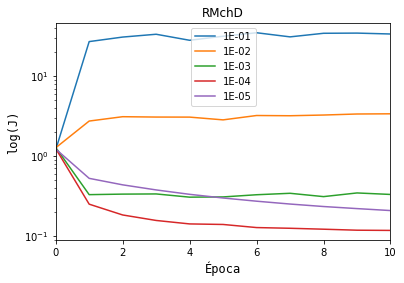

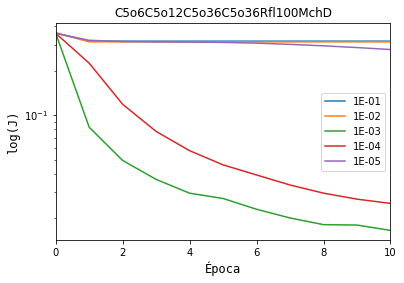

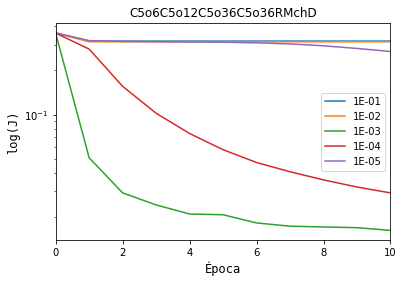

In [6]:
basepath = './partial/'
pickle_files = [basepath + n for n in  os.listdir(basepath) if '.pkl' in n]

reports_by_model = {}

for fname in pickle_files:
    report = open_report(fname, verbose=False)
    model_spec = str(report['model_name'])
    
    if not reports_by_model.get(model_spec, None):
        reports_by_model[model_spec] = []
    
    reports_by_model[model_spec].append(report)

for model_spec, experiments in reports_by_model.items():
    plt.figure()
    #model_name = report.get('model_name', '\n'.join(experiments['model']))
    for experiment in sorted(experiments, key=lambda x: x['lrange'][0], reverse=True):
        cost = experiment['df_test']['loss_avg']
        x = np.arange(len(cost))
        
        #plt.figure()
        #if experiment['lrange'][0] < 0.1:
        #plt.plot(x, cost, label=list(reversed(experiment['lrange'])))
        plt.plot(x, cost, label='{:.0E}'.format(experiment['lrange'][0]))
        #print(experiment['lrange'][0])
    
    #plt.xlim([0, 20])
    
    font_params = {'family': 'monospace', 'size': 'large', }
    
    plt.yscale('log')
    plt.xlim([0, 10])
    plt.ylabel('log(J)', **font_params)
    plt.xlabel('Época', **font_params)
    plt.title(model_spec)
    plt.legend()


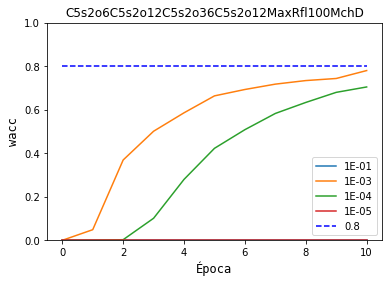

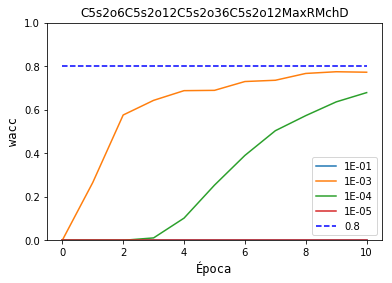

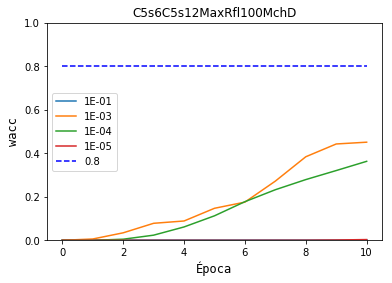

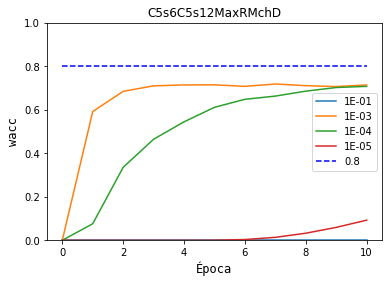

In [4]:
for model_spec, experiments in reports_by_model.items():
    plt.figure()
    #model_name = report.get('model_name', '\n'.join(experiments['model']))
    for experiment in sorted(experiments, key=lambda x: x['lrange'][0], reverse=True):
        cost = experiment['df_test']['wacc']
        x = np.arange(len(cost))
        
        #plt.figure()
        #if experiment['lrange'][0] < 0.1:
        #plt.plot(x, cost, label=list(reversed(experiment['lrange'])))
        plt.plot(x, cost, label='{:.0E}'.format(experiment['lrange'][0]))
        #print(experiment['lrange'][0])
    
    #plt.xlim([0, 20])
    
    font_params = {'family': 'monospace', 'size': 'large', }
    
    #plt.xlim()
    plt.plot(x, 0.8 * np.ones(x.shape), 'b--', label='0.8')
    plt.ylim([0, 1])
    plt.ylabel('wacc', **font_params)
    plt.xlabel('Época', **font_params)
    plt.title(model_spec)
    plt.legend()

In [ ]:
for model_spec, experiments in reports_by_model.items():
    plt.figure()
    model_name = report.get('model_name', '\n'.join(report['model']))
    plt.title(model_name)
    for experiment in sorted(experiments, key=lambda x: x['lrange'][0], reverse=True):
        cost = experiment['df_test']['loss_avg']
        x = np.arange(len(cost))
        
        #plt.figure()
        #if experiment['lrange'][0] < 0.1:
        #plt.plot(x, cost, label=list(reversed(experiment['lrange'])))
        plt.plot(x, cost, label='{:.0E}'.format(experiment['lrange'][0]))
    
    plt.legend()

In [ ]:

for model_spec, experiments in reports_by_model.items():

    #model_name = report.get('model_name', '\n'.join(experiments['model']))
    for experiment in sorted(experiments, key=lambda x: x['lrange'][0], reverse=True):
        cost = experiment['df_test']['wacc']
        x = np.arange(len(cost))
        
        #plt.figure()
        #if experiment['lrange'][0] < 0.1:
        #plt.plot(x, cost, label=list(reversed(experiment['lrange'])))
        plt.plot(x, cost, label='{:.0E}'.format(experiment['lrange'][0]))
        #print(experiment['lrange'][0])
    
    #plt.xlim([0, 20])
    
    font_params = {'family': 'monospace', 'size': 'large', }
    
    #plt.xlim()
    plt.plot(x, 0.8 * np.ones(x.shape), 'b--', label='0.8')
    plt.ylim([0, 1])
    plt.ylabel('wacc', **font_params)
    plt.xlabel('Época', **font_params)
    plt.title(model_spec)
    plt.legend()

In [7]:
old_names = [
    'RMch',
    'RMchD',
    'C5s6RMch',
    'C5s6MaxRMch',
    'C5s6MaxRMchD',
    'C5s6C5s12MaxRMchD',
    'C5s6C5s12MaxRfl100MchD',
    'C5s2o6C5s2o12C5s2o36C5s2o12MaxRMchD',
    'C5s2o6C5s2o12C5s2o36C5s2o12MaxRfl100MchD',
]

new_names = [
    'RMch',
    'RMchD',
    'C5o6RMch',
    'C5o6MaxRMch',
    'C5o6MaxRMchD',
    'C5o6C5o12MaxRMchD',
    'C5o6C5o12MaxRfl100MchD',
    'C5o6C5o12C5o36C5o12MaxRMchD',
    'C5o6C5o12C5o36C5o12MaxRfl100MchD', 
]

basepath = './partial/'
pickle_files = [basepath + n for n in  os.listdir(basepath) if '.pkl' in n]


reports_dict = []
reports_by_model = {}


for fname in pickle_files:
    report = open_report(fname, verbose=False)
    df_train, df_test =  report['df_train'], report['df_test']
    model_spec = report['model_name']
    
    if not reports_by_model.get(model_spec, None):
        reports_by_model[model_spec] = []
    
    reports_by_model[model_spec].append(report)

    
    if True: # df_train['loss_avg'].iloc[-1] > 0 and df_train['wacc'].iloc[-1] > 0:
        train_time_series = df_test['train_time'].as_matrix()[1:]
        total_time_series = df_test['total_time'].as_matrix()[1:]
        
        reports_dict.append({
            'name': report['model_name'],
            'lrate': report['lrange'][0],
            'train_loss': df_train['loss_avg'].iloc[-1],
            'test_loss': df_test['loss_avg'].iloc[-1],
            'train_wacc': df_train['wacc'].iloc[-1],
            'test_wacc': df_test['wacc'].iloc[-1],
            'test_wacc_max': df_test['wacc'].max(),
            'mean_time': train_time_series.mean(),
            'std_time': train_time_series.std(),
            'total_std_time': total_time_series.std(),
            'total_mean_time': total_time_series.mean(),
            'size': report['model_size']
        })
    
df_comp = pd.DataFrame(reports_dict)

In [9]:
import re

groups = df_comp.groupby('name')

net_sizes = []
net_train_times = []
net_total_times = []
net_final_acc1 = []
net_final_acc2 = []

for k, (old_name, new_name) in enumerate(zip(old_names, new_names)):
#for name, group in df_comp.groupby('name'):
    #print()
    #print('model: {} ({} parameters)'.format(name, group['size'].iloc[-1]))
    #print(group[['lrate', 'test_loss', 'test_wacc', 'test_wacc_max', 'mean_time', 'std_time']].sort_values('lrate', ascending=False))
    
    #print('{}\n({}'.format(name, group['size'].iloc[-1]))
    group = groups.get_group(old_name)
    print('%' + new_name)    
    #print('\hline')
    
    model = '\multirow{{2}}{{*}}{{({}) {:1.1e} params.}}'.format('abcdefghi'[k], group['size'].iloc[-1])
    #print(re.sub('e\+0(\d)', ' $10^{\g<1>}$', model))
    
    form = '& {:1.0e} & {:1.2e} & {:1.2e} & {:.2f} & {:.2f} & {:.2f} \\\\ \cline{{2-7}}'
    columns = ['lrate', 'train_loss', 'test_loss', 'train_wacc', 'test_wacc']
    data = group[columns].sort_values('lrate', ascending=False)
    data['loss_rel'] = data['test_loss']/data['train_loss'] - 1
    
    #print(data[data['lrate'].isin([0.001, 0.0001])])
    #continue
    
    for row in data[data['lrate'].isin([0.001, 0.0001])].iterrows():
        #print(*row[1].as_matrix())
        #print(re.sub('e-0(\d)', ' $10^{-\g<1>}$', form.format(*row[1].as_matrix())))
        pass

    data1 = data[data['lrate'] == 0.001]['test_wacc'].as_matrix()[0]
    net_final_acc1.append(data1)
    
    data2 = data[data['lrate'] == 0.0001]['test_wacc'].as_matrix()[0]
    net_final_acc2.append(data2)

    
    columns_time = ['lrate', 'mean_time', 'std_time', 'total_mean_time', 'total_std_time']
    data = group[columns_time].sort_values('lrate', ascending=False)
    #data['std_timep'] = data['std_time']/data['mean_time']
    #data['total_std_timep'] = data['total_std_time']/data['total_mean_time']
    data = data[data['lrate'] == 0.0001]
    
    times = data[['mean_time', 'std_time', 'total_mean_time', 'total_std_time']].as_matrix()[0]
    times = '{:.2f} $(\pm {:.2f})$ & {:.2f} $(\pm {:.2f})$ \\\\ \hline'.format(*times)
    
    #print('({}) & {} & {:1.1e} params. & '.format('abcdefghi'[k], new_name, group['size'].iloc[-1]) + times)
    
    times = data[['mean_time', 'std_time', 'total_mean_time', 'total_std_time']].as_matrix()[0]
    net_sizes.append(group['size'].iloc[-1])
    net_train_times.append(times[0])
    net_total_times.append(times[2])


    #print(data[['mean_time', 'std_time', 'total_mean_time', 'total_std_time']].as_matrix()[0])
    
    print(data[['mean_time', 'std_time', 'total_mean_time', 'total_std_time']])

%RMch
   mean_time  std_time  total_mean_time  total_std_time
2  72.613481  0.058415       100.942723        0.175008
%RMchD
    mean_time  std_time  total_mean_time  total_std_time
12  75.898028   0.02672       108.054004        0.053885


KeyError: 'C5s6RMch'

In [ ]:
#plt.figure()
#plt.plot(net_sizes, net_train_times, 'o')
#plt.plot(net_sizes, net_total_times, 'o')
#plt.yscale('log')
#plt.plot(net_sizes, net_final_acc1, 'o')


In [ ]:
net_final_acc1

In [ ]:
plt.figure()
for report in reports_by_model['RMch']:
    df_train = report['df_train']
    lrate = report['lrange'][0]
    plt.plot(df_train['epoch'], np.log(df_train['loss_avg']), label='{:1.0e}'.format(lrate))

plt.legend()

RMch RMch
RMchD RMchD
C5o6RMch C5s6RMch
C5o6MaxRMch C5s6MaxRMch
C5o6MaxRMchD C5s6MaxRMchD
C5o6C5o12MaxRMchD C5s6C5s12MaxRMchD
C5o6C5o12MaxRfl100MchD C5s6C5s12MaxRfl100MchD
C5o6C5o12C5o36C5o12MaxRMchD C5s2o6C5s2o12C5s2o36C5s2o12MaxRMchD
C5o6C5o12C5o36C5o12MaxRfl100MchD C5s2o6C5s2o12C5s2o36C5s2o12MaxRfl100MchD


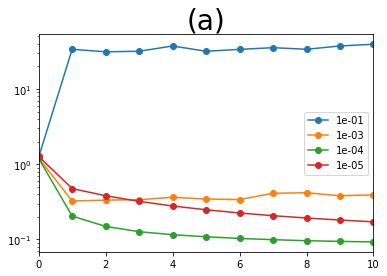

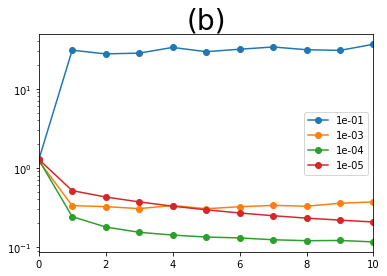

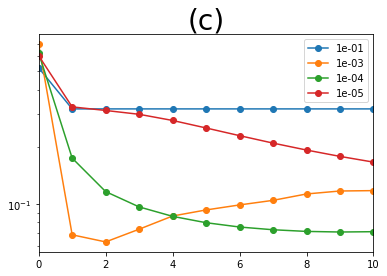

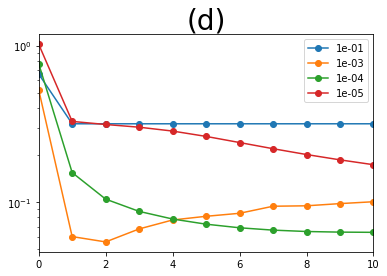

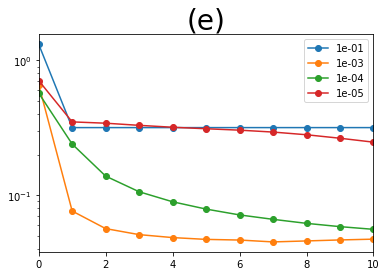

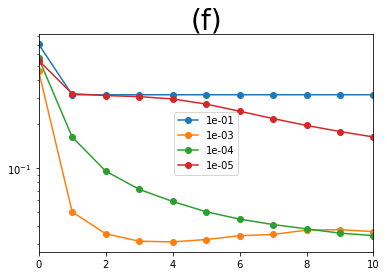

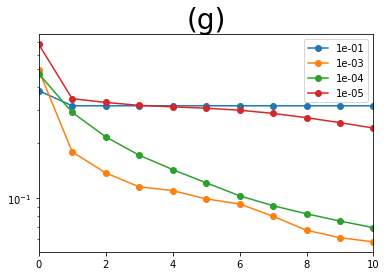

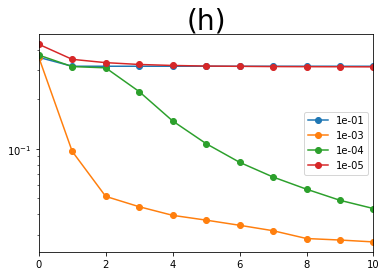

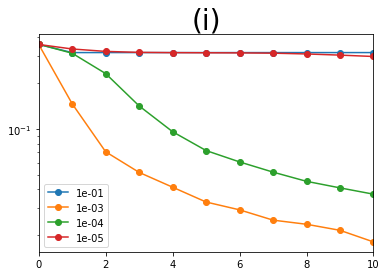

In [7]:
old_names = [
    'RMch',
    'RMchD',
    'C5s6RMch',
    'C5s6MaxRMch',
    'C5s6MaxRMchD',
    'C5s6C5s12MaxRMchD',
    'C5s6C5s12MaxRfl100MchD',
    'C5s2o6C5s2o12C5s2o36C5s2o12MaxRMchD',
    'C5s2o6C5s2o12C5s2o36C5s2o12MaxRfl100MchD', 
]

new_names = [
    'RMch',
    'RMchD',
    'C5o6RMch',
    'C5o6MaxRMch',
    'C5o6MaxRMchD',
    'C5o6C5o12MaxRMchD',
    'C5o6C5o12MaxRfl100MchD',
    'C5o6C5o12C5o36C5o12MaxRMchD',
    'C5o6C5o12C5o36C5o12MaxRfl100MchD', 
]


#for model_spec, experiments in reports_by_model.items():
for k, (new_name, old_name) in enumerate(zip(new_names, old_names)):
    experiments = reports_by_model[old_name]
    
    plt.figure(k)
    for experiment in sorted(experiments, key=lambda x: x['lrange'][0], reverse=True):
        cost = experiment['df_test']['loss_avg']
        x = experiment['df_test']['epoch']
        
        plt.plot(x, cost, 'o-', label='{:1.0e}'.format(experiment['lrange'][0]))
    
    font_params = {'family': 'monospace', 'size': 'large', }    
    plt.yscale('log')
    plt.xlim([0, 10])
    #plt.ylabel('log(J)', **font_params)
    
    #plt.xlabel('Época', **font_params)
    #plt.title(new_name)
    plt.title('({})'.format('abcdefghi'[k]), **{'size': 28})
    plt.legend()
    #plt.savefig('../../reports/tcc/figuras/{}.eps'.format(old_name))
    #plt.close()
    
    print(new_name, old_name)



In [ ]:
['figuras/' + k + '.eps' for k in reports_by_model.keys()]

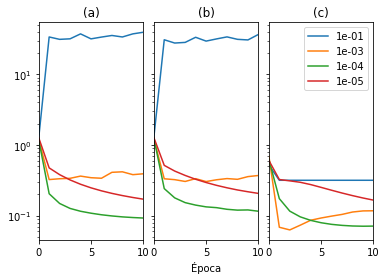

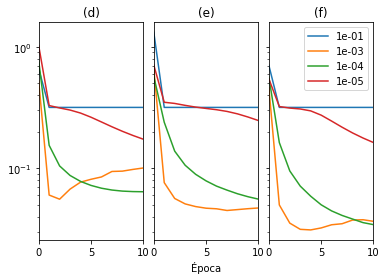

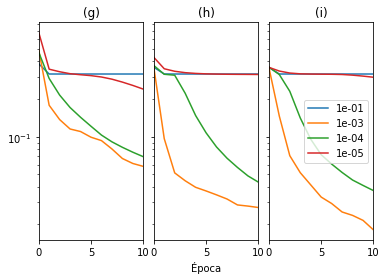

In [6]:
old_names = [
    'RMch',
    'RMchD',
    'C5s6RMch',
    'C5s6MaxRMch',
    'C5s6MaxRMchD',
    'C5s6C5s12MaxRMchD',
    'C5s6C5s12MaxRfl100MchD',
    'C5s2o6C5s2o12C5s2o36C5s2o12MaxRMchD',
    'C5s2o6C5s2o12C5s2o36C5s2o12MaxRfl100MchD', 
]

new_names = [
    'RMch',
    'RMchD',
    'C5o6RMch',
    'C5o6MaxRMch',
    'C5o6MaxRMchD',
    'C5o6C5o12MaxRMchD',
    'C5o6C5o12MaxRfl100MchD',
    'C5o6C5o12C5o36C5o12MaxRMchD',
    'C5o6C5o12C5o36C5o12MaxRfl100MchD', 
]

#fig, axes = plt.subplots(len(new_names), 1, sharex=True, figsize=(30, 20))
#fig.subplots_adjust(hspace=0)
#axes[-1].set(xlabel='Época')

font_params = {'family': 'monospace', 'size': 'large', }

for k, (new_name, old_name) in enumerate(zip(new_names, old_names)):
    if k%3 == 0:
        plt.figure(k//3)
        fig, axes = plt.subplots(1, 3, sharey=True)
        axes[1].set(xlabel='Época')
        fig.subplots_adjust(wspace=0.1)
        #axes[0].ylabel('log(J)', **font_params)
    
    #plt.subplot(1, 3, k%3 + 1)

    #plt.subplot(len(new_names), 1, k+1)

    experiments = reports_by_model[old_name]
    for experiment in sorted(experiments, key=lambda x: x['lrange'][0], reverse=True):
        cost = experiment['df_test']['loss_avg']
        x = experiment['df_test']['epoch']
        
        axes[k%3].plot(x, cost, label='{:1.0e}'.format(experiment['lrange'][0]))
    
    axes[k%3].set(yscale='log', xlim=[0, 10])
    
    #if k%3 == 0:
    #    plt.ylabel('log(J)', **font_params)
    
    if k%3 == 2:
        axes[k%3].legend()
    
    axes[k%3].set(title='({})'.format('abcdefghijk'[k]))
    #plt.title(new_name)
    #plt.yscale('log')
    #plt.xlim([0, 10])
    #plt.ylabel('log(J)', **font_params)
    #plt.xlabel('Época', **font_params)
    #plt.title(model_spec)
    #ax.legend()

    #print(new_name, old_name)


In [ ]:

for lrate in [0.1, 0.001, 0.0001, 0.00001]:
    experiments = []
    
    for name, reports in reports_by_model.items():
        for report in reports:
            if report['lrange'][0] == lrate:
                experiments.append(report)

    plt.figure()
    for experiment in sorted(experiments, key=lambda x: x['model_name']):
        cost = experiment['df_test']['loss_avg']
        x = experiment['df_test']['epoch']
        name = experiment['model_name']
        
        plt.plot(x, cost, label=name)
            
    font_params = {'family': 'monospace', 'size': 'large', }    
    #plt.yscale('log')
    plt.xlim([0, 10])
    plt.ylabel('log(J)', **font_params)
    
    plt.xlabel('Época', **font_params)
    plt.title('lrate: {}'.format(lrate))
    #plt.legend()
    #plt.savefig('../../reports/tcc/figuras/{}.eps'.format(old_name))
    #plt.close()
    
    #print(new_name, old_name)

RMch RMch (0.0001, 0.0001)
RMchD RMchD (0.0001, 0.0001)
C5o6RMch C5s6RMch (0.0001, 0.0001)
C5o6MaxRMch C5s6MaxRMch (0.0001, 0.0001)
C5o6MaxRMchD C5s6MaxRMchD (0.0001, 0.0001)
C5o6C5o12MaxRMchD C5s6C5s12MaxRMchD (0.0001, 0.0001)
C5o6C5o12MaxRfl100MchD C5s6C5s12MaxRfl100MchD (0.0001, 0.0001)
C5o6C5o12C5o36C5o12MaxRMchD C5s2o6C5s2o12C5s2o36C5s2o12MaxRMchD (0.0001, 0.0001)
C5o6C5o12C5o36C5o12MaxRfl100MchD C5s2o6C5s2o12C5s2o36C5s2o12MaxRfl100MchD (0.0001, 0.0001)


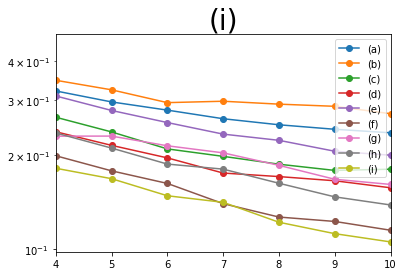

In [21]:
old_names = [
    'RMch',
    'RMchD',
    'C5s6RMch',
    'C5s6MaxRMch',
    'C5s6MaxRMchD',
    'C5s6C5s12MaxRMchD',
    'C5s6C5s12MaxRfl100MchD',
    'C5s2o6C5s2o12C5s2o36C5s2o12MaxRMchD',
    'C5s2o6C5s2o12C5s2o36C5s2o12MaxRfl100MchD', 
]

new_names = [
    'RMch',
    'RMchD',
    'C5o6RMch',
    'C5o6MaxRMch',
    'C5o6MaxRMchD',
    'C5o6C5o12MaxRMchD',
    'C5o6C5o12MaxRfl100MchD',
    'C5o6C5o12C5o36C5o12MaxRMchD',
    'C5o6C5o12C5o36C5o12MaxRfl100MchD', 
]


#for model_spec, experiments in reports_by_model.items():

plt.figure()
for k, (new_name, old_name) in enumerate(zip(new_names, old_names)):
    experiments = reports_by_model[old_name]
    
    for experiment in sorted(experiments, key=lambda x: x['lrange'][0], reverse=True):
        cost = experiment['df_test']['loss_avg']
        wacc = experiment['df_test']['wacc']
        wprob = experiment['df_test']['wprob']
        x = experiment['df_test']['epoch']
        if experiment['lrange'][0] == 0.0001:
            break
    y = (wacc - wprob)/wacc
    
    #def KLDivergence(P, Q):
    #    return (P * np.log2(P/Q)) + ((1-P)*np.log2((1-P)/(1-Q))) 
    
    #y = KLDivergence(wacc, wprob)
    
    plt.plot(x, y, 'o-', label='({})'.format('abcdefghij'[k]))
    
    font_params = {'family': 'monospace', 'size': 'large', }    
    #plt.yscale('log')
    plt.xlim([4, 10])
    #plt.ylabel('log(J)', **font_params)
    
    plt.yscale('log')
    
    #plt.xlabel('Época', **font_params)
    #plt.title(new_name)
    plt.title('({})'.format('abcdefghi'[k]), **{'size': 28})
    plt.legend()
    #plt.savefig('../../reports/tcc/figuras/{}.eps'.format(old_name))
    #plt.close()
    
    print(new_name, old_name, experiment['lrange'])


['C5o6RMchD', 'C5o6C5o12RMchD', 'C5o6C5o12Rfl100MchD', 'RMchD', 'RMch', 'C5o6RMch', 'C5o6C5o12C5o36C5o36Rfl100MchD', 'C5o6C5o12C5o36C5o36RMchD']
[5, 5, 5, 5, 5, 5, 5, 5]


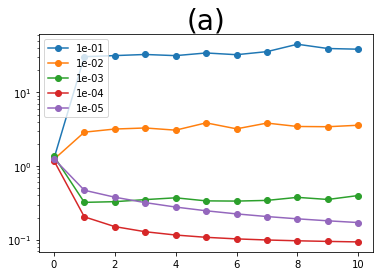

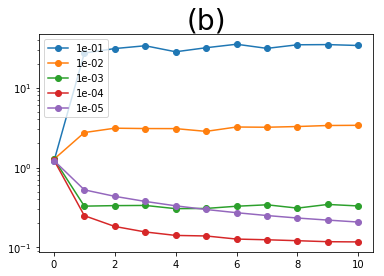

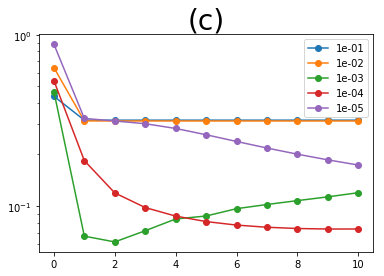

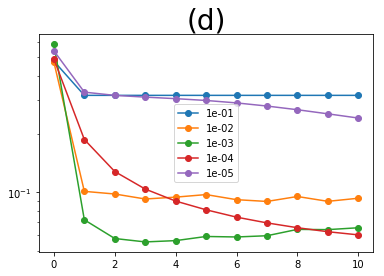

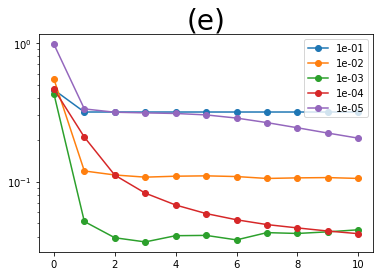

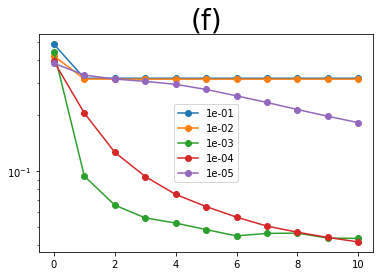

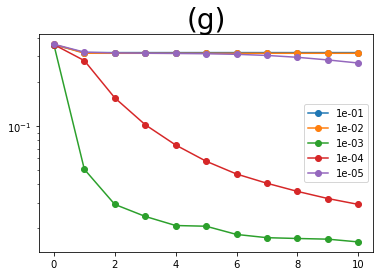

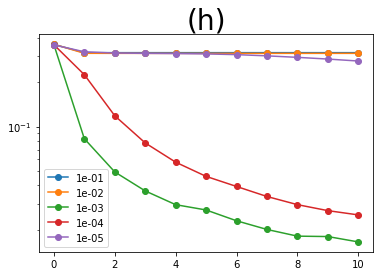

In [36]:
MODEL_ALIAS = 'abcdefghijklmnopqrstuvxwz'

for k, model in enumerate(models):
    reports = reports_by_model[model]
        
    plt.figure(k)
    for report in sorted(reports, key=lambda x: x['lrange'][0], reverse=True):
        cost = report['df_test']['loss_avg']
        x = report['df_test']['epoch']
        plt.plot(x, cost, 'o-', label='{:1.0e}'.format(report['lrange'][0]))
    
    font_params = {'family': 'monospace', 'size': 'large', }    
    plt.yscale('log')
    plt.title('({})'.format(MODEL_ALIAS[k]), **{'size': 28})
    plt.legend()
    #plt.savefig('../../reports/tcc/figuras/{}.eps'.format(old_name))
    #plt.close()

In [32]:
def build_report_dict(report):
    df_test = report['df_test']
    df_train = report['df_train']
    train_time_series = df_test['train_time'].as_matrix()[1:]
    total_time_series = df_test['total_time'].as_matrix()[1:]
    return {
        'name': report['model_name'],
        'lrate': report['lrange'][0],
        'train_loss': df_train['loss_avg'].iloc[-1],
        'test_loss': df_test['loss_avg'].iloc[-1],
        'train_wacc': df_train['wacc'].iloc[-1],
        'test_wacc': df_test['wacc'].iloc[-1],
        'test_wacc_max': df_test['wacc'].max(),
        'mean_time': train_time_series.mean(),
        'std_time': train_time_series.std(),
        'total_std_time': total_time_series.std(),
        'total_mean_time': total_time_series.mean(),
        'size': report['model_size']
    }

reports_dict_list = []
for model in models:
    reports = reports_by_model[model]
    reports_dict_list.append(build_report_dict(reports_1e3[model]))
    reports_dict_list.append(build_report_dict(reports_1e4[model]))
        
df_comp = pd.DataFrame(reports_dict_list)
reports_groups_by_name = df_comp.groupby('name')

In [33]:
import re

data, group = None, None
def explore_by_group(funct):
    for model in models:
        group = reports_groups_by_name.get_group(model)
        data = funct(group)
        print('\n%',model)
        print(data)

def explore_performance(group):
    columns = ['lrate', 'train_loss', 'test_loss', 'train_wacc', 'test_wacc']
    data = group[columns].sort_values('lrate', ascending=False)
    data['loss_rel'] = data['test_loss']/data['train_loss'] - 1
    return data

def explore_times(group):
    columns_time = ['lrate', 'mean_time', 'std_time', 'total_mean_time', 'total_std_time']
    data = group[columns_time].sort_values('lrate', ascending=False)
    data['dev_time'] = data['std_time']/data['mean_time']
    data['total_dev_time'] = data['total_std_time']/data['total_mean_time']
    return data[['lrate', 'mean_time', 'dev_time', 'total_mean_time', 'total_dev_time']]
    
explore_by_group(explore_performance)
explore_by_group(explore_times)

for model in models:
    continue

    group = reports_groups_by_name.get_group(model)

    columns = ['lrate', 'train_loss', 'test_loss', 'train_wacc', 'test_wacc']
    data = group[columns].sort_values('lrate', ascending=False)
    data['loss_rel'] = data['test_loss']/data['train_loss'] - 1
    print()
    print(model)
    print(data)
    continue
    
#for name, group in df_comp.groupby('name'):
    #print()
    #print('model: {} ({} parameters)'.format(name, group['size'].iloc[-1]))
    #print(group[['lrate', 'test_loss', 'test_wacc', 'test_wacc_max', 'mean_time', 'std_time']].sort_values('lrate', ascending=False))
    
    #print('{}\n({}'.format(name, group['size'].iloc[-1]))
    group = groups.get_group(old_name)
    print('%' + new_name)
    #print('\hline')
    
    model = '\multirow{{2}}{{*}}{{({}) {:1.1e} params.}}'.format('abcdefghi'[k], group['size'].iloc[-1])
    #print(re.sub('e\+0(\d)', ' $10^{\g<1>}$', model))
    
    form = '& {:1.0e} & {:1.2e} & {:1.2e} & {:.2f} & {:.2f} & {:.2f} \\\\ \cline{{2-7}}'
    columns = ['lrate', 'train_loss', 'test_loss', 'train_wacc', 'test_wacc']
    data = group[columns].sort_values('lrate', ascending=False)
    data['loss_rel'] = data['test_loss']/data['train_loss'] - 1
    
    #print(data[data['lrate'].isin([0.001, 0.0001])])
    #continue
    
    for row in data[data['lrate'].isin([0.001, 0.0001])].iterrows():
        #print(*row[1].as_matrix())
        #print(re.sub('e-0(\d)', ' $10^{-\g<1>}$', form.format(*row[1].as_matrix())))
        pass

    data1 = data[data['lrate'] == 0.001]['test_wacc'].as_matrix()[0]
    net_final_acc1.append(data1)
    
    data2 = data[data['lrate'] == 0.0001]['test_wacc'].as_matrix()[0]
    net_final_acc2.append(data2)

    
    columns_time = ['lrate', 'mean_time', 'std_time', 'total_mean_time', 'total_std_time']
    data = group[columns_time].sort_values('lrate', ascending=False)
    #data['std_timep'] = data['std_time']/data['mean_time']
    #data['total_std_timep'] = data['total_std_time']/data['total_mean_time']
    data = data[data['lrate'] == 0.0001]
    
    times = data[['mean_time', 'std_time', 'total_mean_time', 'total_std_time']].as_matrix()[0]
    times = '{:.2f} $(\pm {:.2f})$ & {:.2f} $(\pm {:.2f})$ \\\\ \hline'.format(*times)
    
    #print('({}) & {} & {:1.1e} params. & '.format('abcdefghi'[k], new_name, group['size'].iloc[-1]) + times)
    
    times = data[['mean_time', 'std_time', 'total_mean_time', 'total_std_time']].as_matrix()[0]
    net_sizes.append(group['size'].iloc[-1])
    net_train_times.append(times[0])
    net_total_times.append(times[2])


    #print(data[['mean_time', 'std_time', 'total_mean_time', 'total_std_time']].as_matrix()[0])
    
    print(data[['mean_time', 'std_time', 'total_mean_time', 'total_std_time']])


% RMch
    lrate  train_loss  test_loss  train_wacc  test_wacc  loss_rel
0  0.0010    0.180800   0.398015     0.36828     0.2110  1.201407
1  0.0001    0.047705   0.093437     0.52512     0.2986  0.958637

% RMchD
    lrate  train_loss  test_loss  train_wacc  test_wacc  loss_rel
2  0.0010    0.150130   0.330733     0.43912     0.2636  1.202974
3  0.0001    0.075878   0.117314     0.48756     0.3532  0.546078

% C5o6RMch
    lrate  train_loss  test_loss  train_wacc  test_wacc  loss_rel
4  0.0010    0.002883   0.119610     0.95520     0.4904  40.48776
5  0.0001    0.024080   0.073407     0.74072     0.4120   2.04850

% C5o6RMchD
    lrate  train_loss  test_loss  train_wacc  test_wacc   loss_rel
6  0.0010    0.002803   0.065567     0.96032     0.5582  22.395250
7  0.0001    0.032668   0.060243     0.71572     0.5102   0.844088

% C5o6C5o12RMchD
    lrate  train_loss  test_loss  train_wacc  test_wacc   loss_rel
8  0.0010    0.002333   0.044894     0.96360     0.6810  18.239959
9  0.0001  

['models.base.InputLayer((?, 50, 200, 3) -> (?, 50, 200, 3))',
 'models.conv.ConvLayer((?, 50, 200, 3) -> (?, 46, 196, 6))',
 'models.base.DropOutLayer((?, 46, 196, 6) -> (?, 46, 196, 6))',
 'models.conv.ConvLayer((?, 46, 196, 6) -> (?, 21, 96, 12))',
 'models.base.DropOutLayer((?, 21, 96, 12) -> (?, 21, 96, 12))',
 'models.conv.ConvLayer((?, 21, 96, 12) -> (?, 9, 46, 36))',
 'models.base.DropOutLayer((?, 9, 46, 36) -> (?, 9, 46, 36))',
 'models.conv.ConvLayer((?, 9, 46, 36) -> (?, 3, 21, 36))',
 'models.base.DropOutLayer((?, 3, 21, 36) -> (?, 3, 21, 36))',
 'models.base.LinearReshapeLayer((?, 3, 21, 36) -> (?, 2268))',
 'models.linear.LinearLayer((?, 2268) -> (?, 100))',
 'models.linear.LinearMultiCharOutputLayer((?, 100) -> (?, 5, 36))']